### 패키지 선언

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Dataset 다운로드

In [2]:
# Training dataset 다운로드
cifar100_train = dataset.CIFAR100(root = "./",
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar100_test = dataset.CIFAR100(root = "./",
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

dataLabel = ["apple", "aquarium_fish", "baby", "bear", "beaver",
             "bed", "bee", "beetle", "bicycle", "bottle", "bowl",
             "boy", "bridge", "bus", "butterfly", "camel", "can",
             "castle", "caterpillar", "cattle", "chair", "chimpanzee",
             "clock", "cloud", "cockroach", "couch", "cra", "crocodile",
             "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest",
             "fox", "girl", "hamster", "house", "kangaroo", "keyboard",
             "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster",
             "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom",
             "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck",
             "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon",
             "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew",
             "skunk", "skyscraper", "snail", "snake", "spider", "squirrel",
             "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone",
             "television", "tiger", "tractor", "train", "trout", "tulip",
             "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
             ]

100%|██████████| 169001437/169001437 [00:05<00:00, 32610007.33it/s]


Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


## 신경망 모델 정의
- Fully Connected Layer -> nn.Linear(in_features, out_features)
- Convolutional Layer -> nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
- ReLU -> nn.ReLU()
- Max Pooling -> nn.MaxPool2d(kernel_size, stride)


In [72]:
'''
초기 모델

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
'''

class SimpleCNN(nn.Module):

  def __init__(self):
    super(SimpleCNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

    self.fc1 = nn.Linear(in_features=4096, out_features=2024) # 4096, 2024
    self.fc2 = nn.Linear(in_features=2024, out_features=100) # 2024, 100

    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv_skip1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv_skip2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv_skip3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    #-----------------------------------------------------------------
    # Convolution, ReLU, MaxPool layer
    skip_y = self.conv_skip1(x)
    y = self.relu(self.conv1(x))
    y = y + skip_y
    y = self.max_pool(y)

    skip_y = self.conv_skip2(y)
    y = self.relu(self.conv2(y))
    y = y + skip_y
    y = self.max_pool(y)

    skip_y = self.conv_skip3(y)
    y = self.relu(self.conv3(y))
    y = y + skip_y
    y = self.max_pool(y)
    #-----------------------------------------------------------------

    y = y.view(-1, 4096) # feature map 평탄화

    #-----------------------------------------------------------------
    # Fully Connected, ReLU layer
    y = self.relu(self.fc1(y))
    y = self.fc2(y)
    #-----------------------------------------------------------------

    return y


## Hyper-parameters 지정

In [73]:
batch_size = 100 # 고정값
learning_rate = 0.1 # 가변
training_epochs = 30 # 고정값
loss_function = nn.CrossEntropyLoss() # 가변
network = SimpleCNN().to('cuda')
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate) # 가변

data_loader = DataLoader(dataset=cifar100_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

## CNN 학습을 위한 반복문 선언

In [74]:
for epoch in range(training_epochs):
  network.train()
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:
    img = img.to('cuda')
    label = label.to('cuda')
    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

Epoch: 1 Loss = 3.914755
Epoch: 2 Loss = 3.069475
Epoch: 3 Loss = 2.553084
Epoch: 4 Loss = 2.115431
Epoch: 5 Loss = 1.689973
Epoch: 6 Loss = 1.234741
Epoch: 7 Loss = 0.759313
Epoch: 8 Loss = 0.423749
Epoch: 9 Loss = 0.270158
Epoch: 10 Loss = 0.167417
Epoch: 11 Loss = 0.126553
Epoch: 12 Loss = 0.079215
Epoch: 13 Loss = 0.050262
Epoch: 14 Loss = 0.030964
Epoch: 15 Loss = 0.015848
Epoch: 16 Loss = 0.010474
Epoch: 17 Loss = 0.008715
Epoch: 18 Loss = 0.005912
Epoch: 19 Loss = 0.004884
Epoch: 20 Loss = 0.004589
Epoch: 21 Loss = 0.003946
Epoch: 22 Loss = 0.002792
Epoch: 23 Loss = 0.003253
Epoch: 24 Loss = 0.002644
Epoch: 25 Loss = 0.002242
Epoch: 26 Loss = 0.002454
Epoch: 27 Loss = 0.002212
Epoch: 28 Loss = 0.001900
Epoch: 29 Loss = 0.002067
Epoch: 30 Loss = 0.001695
Learning finished


## 학습이 완료된 모델을 이용해 정답률 확인

In [75]:
network.eval()
network = network.to('cuda')
img_test = torch.tensor(np.transpose(cifar100_test.data,(0,3,1,2))) / 255.
label_test = torch.tensor(cifar100_test.targets)

img_test = img_test.to('cuda')
label_test = label_test.to('cuda')

with torch.no_grad(): # test에서는 기울기 계산 제외
  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.46629998087882996


tensor([[-3.2481e+00,  4.8214e+00,  9.0696e+00,  1.4373e+01,  1.4921e+01,
          5.4030e-01, -4.3335e+00, -3.9042e+00, -1.0686e+01, -1.1330e+01,
         -7.7257e+00,  6.4707e+00,  1.4166e+00,  1.0958e+00,  3.3184e+00,
         -1.0487e+00,  7.0234e+00,  5.4592e+00,  2.6867e+00,  1.5828e+01,
         -8.4434e+00,  3.3080e+01, -6.5924e+00, -3.6820e+00, -1.0672e+01,
          4.2971e+00, -1.9370e+00,  4.3623e-01, -9.0408e+00,  8.7183e-03,
          1.7514e+00,  1.2931e+01, -3.7784e-01, -7.4790e-01, -9.3744e+00,
          9.4075e+00, -7.3213e+00,  5.4090e+00,  1.3730e+01,  2.8137e+00,
         -4.2453e+00, -2.9496e+00,  2.9596e+00, -6.7043e+00, -2.5484e+00,
         -7.6102e+00,  1.1000e+01, -1.8914e+01, -4.1918e+00, -6.3792e+00,
          9.4170e+00, -3.4017e+00, -1.1575e+01, -1.3268e+01, -6.9788e+00,
          6.1934e+00, -1.2519e+01, -8.8937e+00, -5.7444e+00, -8.8084e+00,
         -1.9255e+01,  7.2320e-01, -9.7145e+00,  1.4252e+01,  1.4369e+01,
         -3.5473e-01,  1.3470e+01,  1.

<function matplotlib.pyplot.show(close=None, block=None)>

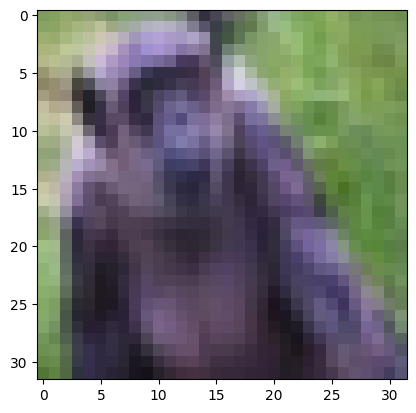

In [76]:
dataIdx = 1199
# tmp_img = img_test[dataIdx] ## dense 를 제외한 부분은 unsqueeze(0) 미포함
tmp_img = img_test[dataIdx].unsqueeze(0)
tmp_label = label_test[dataIdx]

with torch.no_grad():
  prediction = network(tmp_img)
  ## dense 를 제외한 부분은 제외
  tmp_img = tmp_img.squeeze(0)
prediction_num = torch.argmax(prediction, 1)

print(prediction)
print("prediction: ", dataLabel[prediction_num])
print("label: ", dataLabel[tmp_label])

# plt.imshow(np.transpose(tmp_img,(1,2,0))) ## dense 를 제외한 부분은 .to('cpu') 제외
plt.imshow(np.transpose(tmp_img.to('cpu'),(1,2,0)))
plt.show

In [77]:
from torchsummary import summary

summary(SimpleCNN().to('cuda'), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]           1,792
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
           Conv2d-10            [-1, 256, 8, 8]         295,168
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Linear-13                 [-1, 2024]       8,292,328
             ReLU-14                 [-